In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv('Electric_Vehicle_Population_Data.csv', on_bad_lines='skip')

# View variable list
print("\n🔹 Column names:")
print(df.columns.tolist())

# Check basic info
print("\n🔹 Dataset Info:")
print(df.info())

# Preview data
print("\n🔹 First 5 rows:")
print(df.head())


/tmp/ipython-input-2-2734625472.py:4: DtypeWarning: Columns (4,5,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Electric_Vehicle_Population_Data.csv', on_bad_lines='skip')



🔹 Column names:
['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range', 'Base MSRP', 'Legislative District', 'DOL Vehicle ID', 'Vehicle Location', 'Electric Utility', '2020 Census Tract']

🔹 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475165 entries, 0 to 475164
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         475165 non-null  object 
 1   County                                             475156 non-null  object 
 2   City                                               475155 non-null  object 
 3   State                                              475163 non-null  object 
 4   Postal Code                                        475153 non-nu


🔹 Missing values per column:
VIN (1-10)                                              0
County                                                  9
City                                                   10
State                                                   2
Postal Code                                            12
Model Year                                              5
Make                                                    7
Model                                                   9
Electric Vehicle Type                                  11
Clean Alternative Fuel Vehicle (CAFV) Eligibility      13
Electric Range                                         61
Base MSRP                                              69
Legislative District                                 1194
DOL Vehicle ID                                         32
Vehicle Location                                       59
Electric Utility                                       47
2020 Census Tract                         

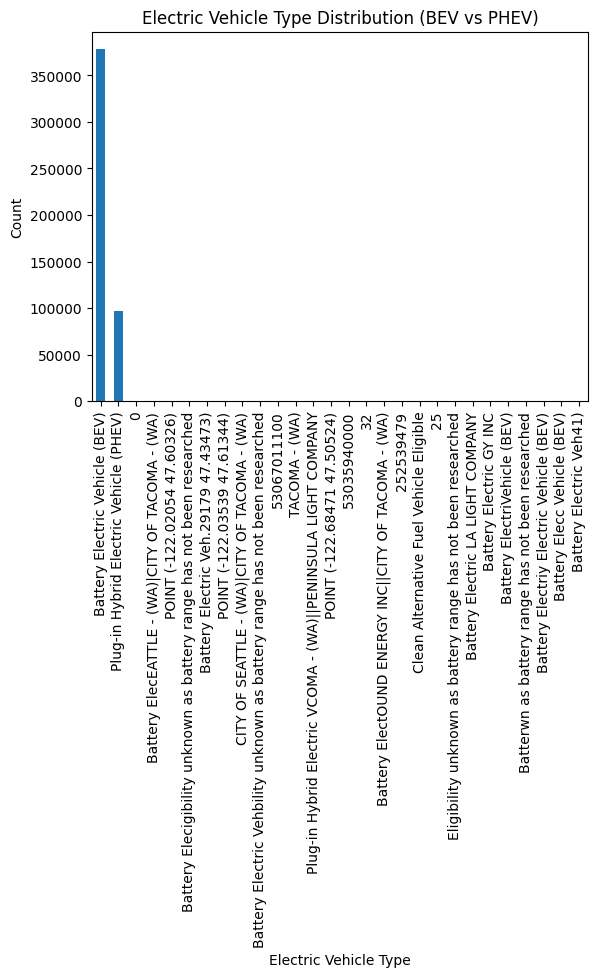

In [3]:
import matplotlib.pyplot as plt

# Missing values
print("\n🔹 Missing values per column:")
print(df.isnull().sum())

# Unique counts
print("\n🔹 Unique values per column:")
print(df.nunique())

# Target column distribution
print("\n🔹 Class distribution:")
print(df['Electric Vehicle Type'].value_counts())

# Plot target distribution
df['Electric Vehicle Type'].value_counts().plot(kind='bar')
plt.title('Electric Vehicle Type Distribution (BEV vs PHEV)')
plt.ylabel('Count')
plt.show()


In [4]:
# Drop irrelevant columns
df_clean = df.drop(['VIN (1-10)', 'DOL Vehicle ID', 'Vehicle Location'], axis=1)

# Fix target column: keep only valid BEV and PHEV
valid_targets = ['Battery Electric Vehicle (BEV)', 'Plug-in Hybrid Electric Vehicle (PHEV)']
df_clean = df_clean[df_clean['Electric Vehicle Type'].isin(valid_targets)]

# Convert numeric-like columns
numeric_cols = ['Model Year', 'Electric Range', 'Base MSRP', 'Postal Code', 'Legislative District']
for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Drop rows with missing target or numeric cols if too many missing
df_clean.dropna(subset=['Electric Vehicle Type'], inplace=True)

# Fill missing numeric with median
for col in numeric_cols:
    df_clean[col].fillna(df_clean[col].median(), inplace=True)

# Check cleaned data
print("Cleaned class distribution:\n", df_clean['Electric Vehicle Type'].value_counts())
print("\nRemaining rows:", df_clean.shape[0])


Cleaned class distribution:
 Electric Vehicle Type
Battery Electric Vehicle (BEV)            378036
Plug-in Hybrid Electric Vehicle (PHEV)     97089
Name: count, dtype: int64

Remaining rows: 475125


/tmp/ipython-input-4-2817591979.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(df_clean[col].median(), inplace=True)


In [5]:
import pandas as pd

# Separate features and target
X = df_clean.drop('Electric Vehicle Type', axis=1)
y = df_clean['Electric Vehicle Type']

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("Shape after encoding:", X_encoded.shape)


Shape after encoding: (475125, 1409)


In [6]:
# Drop columns that are IDs or too unique
cols_to_drop = ['VIN (1-10)', 'DOL Vehicle ID', 'Vehicle Location']
df_reduced = df_clean.drop(columns=[col for col in cols_to_drop if col in df_clean.columns])

# Drop columns with >50% missing values
missing_ratio = df_reduced.isnull().mean()
df_reduced = df_reduced.drop(columns=missing_ratio[missing_ratio > 0.5].index)

print("Remaining columns:", df_reduced.columns.tolist())


Remaining columns: ['County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range', 'Base MSRP', 'Legislative District', 'Electric Utility', '2020 Census Tract']


In [7]:
# Separate features (X) and target (y)
X = df_reduced.drop('Electric Vehicle Type', axis=1)
y = df_reduced['Electric Vehicle Type']

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts())


X shape: (475125, 13)
y distribution:
 Electric Vehicle Type
Battery Electric Vehicle (BEV)            378036
Plug-in Hybrid Electric Vehicle (PHEV)     97089
Name: count, dtype: int64


In [8]:
# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("Shape after encoding:", X_encoded.shape)


Shape after encoding: (475125, 1409)


In [9]:
# Drop columns with >50% missing values first
missing_ratio = X_encoded.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > 0.5].index
X_reduced = X_encoded.drop(columns=cols_to_drop)

print("Shape after dropping high-missing columns:", X_reduced.shape)


Shape after dropping high-missing columns: (475125, 1409)


In [10]:
# Fill numeric with median and categorical with most frequent
for col in X_reduced.columns:
    if X_reduced[col].dtype in ['int64', 'float64']:
        X_reduced[col].fillna(X_reduced[col].median(), inplace=True)
    else:
        X_reduced[col].fillna(X_reduced[col].mode()[0], inplace=True)

print("Remaining missing values:", X_reduced.isnull().sum().sum())


/tmp/ipython-input-10-1143752856.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_reduced[col].fillna(X_reduced[col].median(), inplace=True)
/tmp/ipython-input-10-1143752856.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

Remaining missing values: 0


In [11]:
# Reduce the size of the dataset before SMOTE
sample_fraction = 0.2  # 20% of the dataset
X_sample = X_encoded.sample(frac=sample_fraction, random_state=42)
y_sample = y.loc[X_sample.index]

print("Sampled shape:", X_sample.shape)


Sampled shape: (95025, 1409)


In [12]:
from sklearn.impute import SimpleImputer

# Create an imputer (median for numeric, most frequent for categorical)
imputer = SimpleImputer(strategy='most_frequent')

# Apply imputer to the sampled dataset
X_sample_imputed = imputer.fit_transform(X_sample)

# Convert back to DataFrame (keep column names)
X_sample_imputed = pd.DataFrame(X_sample_imputed, columns=X_sample.columns)

print("Remaining missing values:", X_sample_imputed.isnull().sum().sum())


Remaining missing values: 0


In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_sample_imputed, y_sample)

print("Class distribution after SMOTE:\n", y_resampled.value_counts())


Class distribution after SMOTE:
 Electric Vehicle Type
Battery Electric Vehicle (BEV)            75718
Plug-in Hybrid Electric Vehicle (PHEV)    75718
Name: count, dtype: int64


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import pandas as pd

# --- Separate features and target ---
X = df_reduced.drop('Electric Vehicle Type', axis=1)
y = df_reduced['Electric Vehicle Type']

# --- Identify categorical and numeric columns ---
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(exclude=['object']).columns

# --- Build column transformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ]
)

# --- Fit-transform the data ---
X_preprocessed = preprocessor.fit_transform(X)


In [15]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

print("Class distribution after SMOTE:\n", y_resampled.value_counts())


Class distribution after SMOTE:
 Electric Vehicle Type
Battery Electric Vehicle (BEV)            378036
Plug-in Hybrid Electric Vehicle (PHEV)    378036
Name: count, dtype: int64


In [16]:
# Reduce dataset to first 20,000 rows
X_small = X_preprocessed[:20000]
y_small = y[:20000]


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small, test_size=0.2, stratify=y_small, random_state=42
)


In [18]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Train SVM
svm_model = SVC(probability=True, kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

# Predictions
y_pred = svm_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.80225

Classification Report:
                                         precision    recall  f1-score   support

        Battery Electric Vehicle (BEV)       0.80      1.00      0.89      3209
Plug-in Hybrid Electric Vehicle (PHEV)       0.00      0.00      0.00       791

                              accuracy                           0.80      4000
                             macro avg       0.40      0.50      0.45      4000
                          weighted avg       0.64      0.80      0.71      4000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_model = GradientBoostingClassifier(random_state=42)
gbm_model.fit(X_train, y_train)
y_pred_gbm = gbm_model.predict(X_test)

print("GBM Accuracy:", accuracy_score(y_test, y_pred_gbm))
print("\nGBM Classification Report:\n", classification_report(y_test, y_pred_gbm))


GBM Accuracy: 1.0

GBM Classification Report:
                                         precision    recall  f1-score   support

        Battery Electric Vehicle (BEV)       1.00      1.00      1.00      3209
Plug-in Hybrid Electric Vehicle (PHEV)       1.00      1.00      1.00       791

                              accuracy                           1.00      4000
                             macro avg       1.00      1.00      1.00      4000
                          weighted avg       1.00      1.00      1.00      4000



In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Fix: with_mean=False for sparse matrices
svm_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('svm', SVC(probability=True, kernel='rbf', class_weight='balanced', random_state=42))
])

svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)

print("Balanced SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))


Balanced SVM Accuracy: 0.80225

Classification Report:
                                         precision    recall  f1-score   support

        Battery Electric Vehicle (BEV)       0.80      1.00      0.89      3209
Plug-in Hybrid Electric Vehicle (PHEV)       0.00      0.00      0.00       791

                              accuracy                           0.80      4000
                             macro avg       0.40      0.50      0.45      4000
                          weighted avg       0.64      0.80      0.71      4000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto', 0.01, 0.001],
    'svm__kernel': ['rbf']
}

grid = GridSearchCV(svm_pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
y_pred_svm = grid.predict(X_test)
print(classification_report(y_test, y_pred_svm))


Best Params: {'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
                                        precision    recall  f1-score   support

        Battery Electric Vehicle (BEV)       1.00      1.00      1.00      3209
Plug-in Hybrid Electric Vehicle (PHEV)       0.99      0.98      0.99       791

                              accuracy                           0.99      4000
                             macro avg       0.99      0.99      0.99      4000
                          weighted avg       0.99      0.99      0.99      4000



In [23]:
from sklearn.ensemble import GradientBoostingClassifier

# Define GBM model and parameter grid
gbm = GradientBoostingClassifier(random_state=42)
param_grid_gbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

# Grid search with f1_macro scoring
grid_gbm = GridSearchCV(gbm, param_grid_gbm, cv=3, scoring='f1_macro', n_jobs=-1)
grid_gbm.fit(X_train, y_train)

# Predictions
print("Best GBM Params:", grid_gbm.best_params_)
y_pred_gbm = grid_gbm.predict(X_test)

# Evaluation
print("Tuned GBM Accuracy:", accuracy_score(y_test, y_pred_gbm))
print("\nGBM Classification Report:\n", classification_report(y_test, y_pred_gbm))


Best GBM Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Tuned GBM Accuracy: 1.0

GBM Classification Report:
                                         precision    recall  f1-score   support

        Battery Electric Vehicle (BEV)       1.00      1.00      1.00      3209
Plug-in Hybrid Electric Vehicle (PHEV)       1.00      1.00      1.00       791

                              accuracy                           1.00      4000
                             macro avg       1.00      1.00      1.00      4000
                          weighted avg       1.00      1.00      1.00      4000



In [24]:
from sklearn.ensemble import VotingClassifier

# Hybrid model using soft voting
hybrid = VotingClassifier(
    estimators=[
        ('svm', grid.best_estimator_),
        ('gbm', grid_gbm.best_estimator_)
    ],
    voting='soft'
)

# Fit and evaluate
hybrid.fit(X_train, y_train)
y_pred_hybrid = hybrid.predict(X_test)

print("Hybrid Accuracy:", accuracy_score(y_test, y_pred_hybrid))
print("\nHybrid Classification Report:\n", classification_report(y_test, y_pred_hybrid))


Hybrid Accuracy: 1.0

Hybrid Classification Report:
                                         precision    recall  f1-score   support

        Battery Electric Vehicle (BEV)       1.00      1.00      1.00      3209
Plug-in Hybrid Electric Vehicle (PHEV)       1.00      1.00      1.00       791

                              accuracy                           1.00      4000
                             macro avg       1.00      1.00      1.00      4000
                          weighted avg       1.00      1.00      1.00      4000



In [27]:
from sklearn.model_selection import cross_val_score

cv_scores_svm = cross_val_score(grid.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_gbm = cross_val_score(grid_gbm.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_hybrid = cross_val_score(hybrid, X_train, y_train, cv=5, scoring='accuracy')

print("SVM CV Accuracy:", cv_scores_svm.mean())
print("GBM CV Accuracy:", cv_scores_gbm.mean())
print("Hybrid CV Accuracy:", cv_scores_hybrid.mean())


SVM CV Accuracy: 0.9942500000000001
GBM CV Accuracy: 0.9996875
Hybrid CV Accuracy: 0.99975


In [31]:
from sklearn.preprocessing import LabelBinarizer

# Convert y_test to 0 and 1
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test).ravel()   # ravel() makes it 1D

# Now calculate ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test_bin, y_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_gbm, tpr_gbm, _ = roc_curve(y_test_bin, y_proba_gbm)
roc_auc_gbm = auc(fpr_gbm, tpr_gbm)

fpr_hybrid, tpr_hybrid, _ = roc_curve(y_test_bin, y_proba_hybrid)
roc_auc_hybrid = auc(fpr_hybrid, tpr_hybrid)


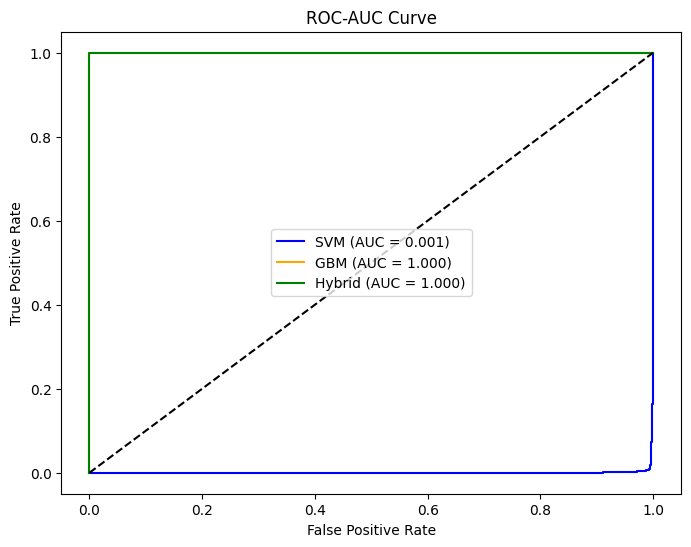

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# 1️⃣ Convert y_test to binary (0,1) using LabelBinarizer
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test).ravel()

# Positive class index (PHEV)
positive_class_index = lb.transform(['Plug-in Hybrid Electric Vehicle (PHEV)'])[0]

# 2️⃣ Get probabilities for positive class
# SVM must have been trained with probability=True
y_proba_svm = svm_pipeline.predict_proba(X_test)[:, positive_class_index]
y_proba_gbm = grid_gbm.best_estimator_.predict_proba(X_test)[:, positive_class_index]
y_proba_hybrid = hybrid.predict_proba(X_test)[:, positive_class_index]

# 3️⃣ Calculate ROC curves and AUC
fpr_svm, tpr_svm, _ = roc_curve(y_test_bin, y_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_gbm, tpr_gbm, _ = roc_curve(y_test_bin, y_proba_gbm)
roc_auc_gbm = auc(fpr_gbm, tpr_gbm)

fpr_hybrid, tpr_hybrid, _ = roc_curve(y_test_bin, y_proba_hybrid)
roc_auc_hybrid = auc(fpr_hybrid, tpr_hybrid)

# 4️⃣ Plot the ROC-AUC curves
plt.figure(figsize=(8,6))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.3f})", color='blue')
plt.plot(fpr_gbm, tpr_gbm, label=f"GBM (AUC = {roc_auc_gbm:.3f})", color='orange')
plt.plot(fpr_hybrid, tpr_hybrid, label=f"Hybrid (AUC = {roc_auc_hybrid:.3f})", color='green')
plt.plot([0,1], [0,1], linestyle='--', color='black')

plt.title("ROC-AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
